# Non-Negative Matrix Factorization

### An example with cat images is given for simplicity, and a reference to an article using the same methods but for cortical thickness voxel based analysis of the NNMF extracted networks.

In [ ]:
%matplotlib inline
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
#import skimage
from sklearn.decomposition import NMF
np.random.seed(1)

In [9]:
def NNMF_fit(nc,data):
    model = NMF(n_components=nc, init='random', random_state=0)
    W = model.fit(data)
    H = model.components_
    return W,H

def load_data():
    train_dataset = h5py.File('cat-images-dataset/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('cat-images-dataset/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape((64,64)), cmap='gray',
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [90]:
x_train,y_train,x_test,y_test,classes=load_data()

# create mask to grab only cats
cat_idx = y_train == 1
# grayscale cats
x_train_cats = x_train[cat_idx.flatten(),:,:,0]

# flatten
x_train_cats_flat = x_train_cats.reshape(x_train_cats.shape[0], -1)/256
#test_x_flatten = x_test.reshape(x_test.shape[0], -1).T


print(x_train_cats_flat.shape)

(72, 4096)


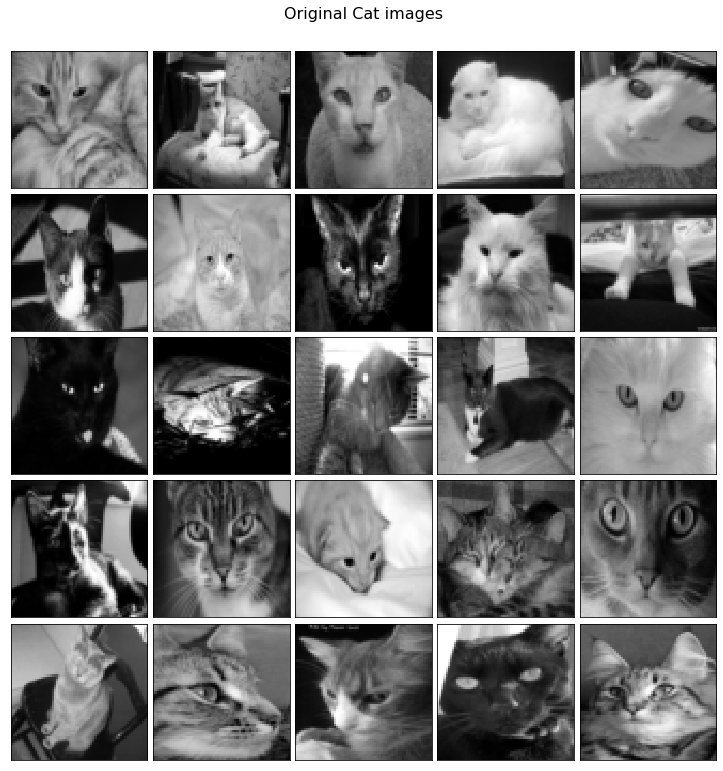

In [91]:
plot_gallery("Original Cat images", x_train_cats[:25,:,:],5,5)

In [92]:
num_components = range(2,30,2)
rec_error = []
rec_error_grad = []
comp_matrix = []
prev_err = NNMF_fit(1,x_train_cats_flat)[0].reconstruction_err_
for i,nc in enumerate(num_components):
    print('Fitting NNMF with {} components...'.format(nc))
    W,H = NNMF_fit(nc,x_train_cats_flat)
    rec_error.append(W.reconstruction_err_)
    grad = rec_error[i] - prev_err
    rec_error_grad.append(grad)
    prev_err = rec_error[i]
    #comp_matrix.append(H)

Fitting NNMF with 2 components...
Fitting NNMF with 4 components...
Fitting NNMF with 6 components...
Fitting NNMF with 8 components...
Fitting NNMF with 10 components...
Fitting NNMF with 12 components...
Fitting NNMF with 14 components...
Fitting NNMF with 16 components...
Fitting NNMF with 18 components...
Fitting NNMF with 20 components...
Fitting NNMF with 22 components...
Fitting NNMF with 24 components...
Fitting NNMF with 26 components...
Fitting NNMF with 28 components...


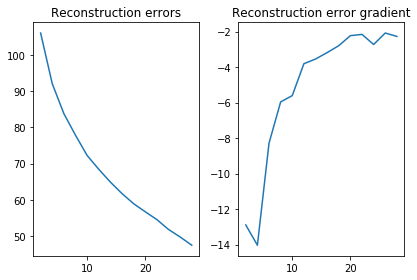

In [93]:
f, axarr = plt.subplots(1,2)
axarr[0].plot(num_components,rec_error)
axarr[0].set_title('Reconstruction errors')
axarr[1].plot(num_components,rec_error_grad)
axarr[1].set_title('Reconstruction error gradient')

f.tight_layout()

 With 22 components, the gradient begins to show less of an increase so with some luck these components will extract the most relevant information from the random noise.

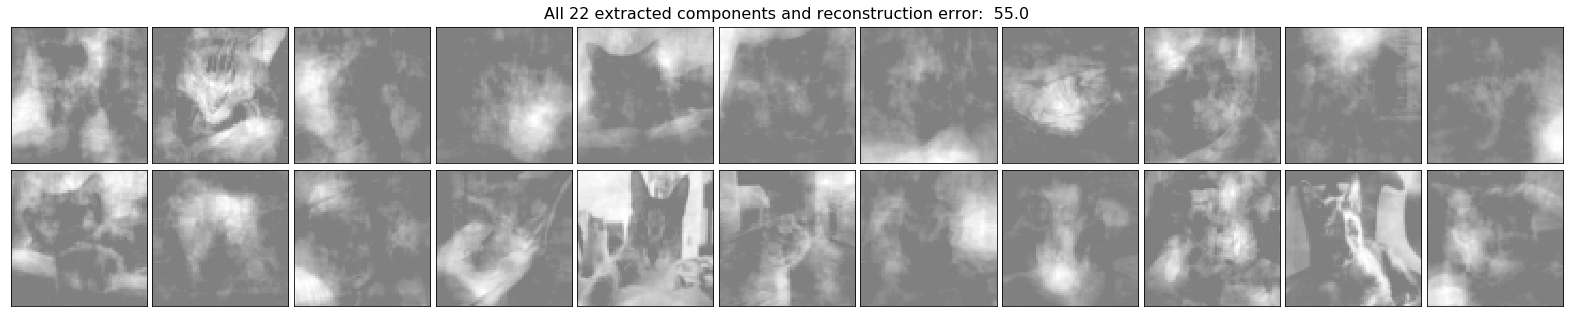

In [94]:
opt_nc = 22
W_opt,final_model =  NNMF_fit(opt_nc,x_train_cats_flat)
plot_gallery("All {} extracted components and reconstruction error:  {}".format(opt_nc,np.round(W_opt.reconstruction_err_)), final_model,opt_nc/2,2)

## On sMRI data

#### The same ideas apply, however instead of "components" they refer to them as networks. The article is actually interesting, in that when they plotted the networks on an inflated brain, they were able to recognize certain known networks. The NNMF works by selecting a subset of features that are most "popular" across all participants, such that the reconstruction error is minimal with respect to a certain cost function (Frobenius norm in this case).

<sub>Diminished Cortical Thickness Is Associated with Impulsive Choice in Adolescence
Marieta Pehlivanova, Daniel H. Wolf, Aristeidis Sotiras, Antonia N. Kaczkurkin, Tyler M. Moore, Rastko Ciric, Philip A. Cook, Angel Garcia de La Garza, Adon F.G. Rosen, Kosha Ruparel, Anup Sharma, Russell T. Shinohara, David R. Roalf, Ruben C. Gur, Christos Davatzikos, Raquel E. Gur, Joseph W. Kable, Theodore D. Satterthwaite
Journal of Neuroscience 7 March 2018, 38 (10) 2471-2481; DOI: 10.1523/JNEUROSCI.2200-17.2018</sub>


![nnmf_smri.png](nnmf_smri.png)

### Relevant excerpt from above implementation:
>Non-negative matrix factorization.Cortical thickness was estimated asdescribed in the previous paragraph over the entire cortical surface. Wesought to reduce CT in our sample into fewer dimensions, for two rea-sons. First, an efficient summary of CT data would allow us to evaluateonly a small number of associations, rather than conduct voxelwise in-ference that may be vulnerable to substantial type I error (Eklund et al.,2016). Second, and importantly, prior work has shown that there areinherent patterns of covariance in CT (Zielinski et al., 2010;Alexander-Bloch et al., 2013;Sotiras et al., 2015,2017), and analyzing the dataaccording to this covariance structure may enhance interpretability.Accordingly, we achieved both goals by using non-negative matrixfactorization (NMF) to identify structural networks where CT covaries consistently across individuals and brain regions (Sotiras et al., 2015).NMF has previously been shown to yield more interpretable and repro-ducible components than other decomposition techniques such as prin-cipal component analysis or independent component analysis (Sotiras etal., 2015,2017). In contrast to the other techniques, NMF only yieldscompact networks with positive weights, which facilitates interpretationof effects.The NMF algorithm takes as input a matrixXcontaining voxelwise CTestimates (dimensions: 128,155 voxels427 participants), and approx-imates that matrix as a product of two matrices with non-negative ele-ments:XBC(Fig. 1). The first matrix,B, is of sizeVKand containsthe estimated non-negative networks and their respective loadings oneach of theVvoxels, whereKis the user-specified number of networks.TheBmatrix (“CT loadings”) is composed of coefficients that denote therelative contribution of each voxel to a given network. These non-negative coefficients of the decomposition by necessity represent theentirety of the brain as a subject-specific addition of various parts. Thesecond matrix,C, is of sizeKNand contains subject-specific scores foreach network. These subject-specific scores (“CT network scores”) indi-cate the contribution of each network in reconstructing the original CTmap for each individual, and were evaluated for associations with DD asdescribed below. We examined multiple NMF solutions ranging from 2to 30 networks (in steps of 2) and calculated reconstruction error for eachsolution as the Frobenius norm between the CT data matrix and itsNMF approximation (Sotiras et al., 2015,2017). The optimal numberof components was chosen based on the elbow of the gradient of thereconstruction error, such that the solution is adequate to model thestructure of the data without modeling random noise (Sotiras et al.,2017). Network loadings were visualized on the inflated population-average, landmark-, and surface-based cortical surfaces (Van Essen,2005; RRID:SCR_002099) using Caret software (Van Essen et al.,2001; RRID:SCR_006260).
<img src="nnmf_rec_error.png" width="400"/> 

<p float="left">
    <img src="nnmf_smri_networks.png" width="600"/>
</p>